## Maths for ML - Coursework 3

## Initialise the data set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

N = 25
X = np.reshape(np.linspace(0, 0.9, N), (N, 1))
Y = np.cos(10*X**2) + 0.1 * np.sin(100*X)

Phi_order_1 = np.ones((N,2))
Phi_order_1[:,1] = X[:,0]

## Calculate the log marginal likelihood (i.e. using prior) and it's gradient. Use gradient descent method to find optimal parameters

In [2]:
# Log marginal likelihood

def lml(alpha, beta, Phi, Y):
    n, m = Phi.shape
    S0 = alpha*np.eye(m)
    
    D = alpha*np.dot(Phi,Phi.T)+ beta*np.eye(n)
    pt_1 = np.log(np.power(2.*np.pi,-n/2.)*np.power(np.linalg.det(D),-0.5))
    pt_2 = -0.5*(np.dot(Y.T,np.dot(np.linalg.inv(D),Y)))
                    
    return (pt_1 + pt_2)[0][0]

In [3]:
# Gradient of log marginal likelihood

def grad_lml(alpha, beta, Phi, Y):
    n, m = Phi.shape
    S0 = alpha*np.eye(m)
    
    A = np.dot(Phi,np.dot(S0,Phi.T))+ beta*np.eye(n)
    A_inv = np.linalg.inv(A)
    cov_mat = np.dot(Phi,Phi.T)
    
    # 1st part diff
    grad_1_alpha = -0.5*np.trace(np.dot(np.linalg.inv(A),cov_mat))
    grad_1_beta = -0.5*np.trace(np.linalg.inv(A))
    
    # 2nd part diff
    grad_2_alpha = 0.5*np.dot(Y.T,np.dot(A_inv,np.dot(cov_mat,np.dot(A_inv,Y))))
    grad_2_beta = 0.5*np.dot(Y.T,np.dot(A_inv,np.dot(A_inv,Y)))
    
    # Combined grads
    grad_alpha = grad_1_alpha + grad_2_alpha
    grad_beta = grad_1_beta + grad_2_beta
    
    return np.array([grad_alpha[0][0], grad_beta[0][0]])


In [4]:
# Gradient descent method to calculate optimal values for parameters

def gradient_descent(alpha_init, beta_init, Phi, Y, learning_rate, tolerance, iterations):
    
    # Initialise the variables:
    alpha_new = np.copy(alpha_init)
    beta_new = np.copy(beta_init)
    
    alpha_values = [alpha_new]
    beta_values = [beta_new]
    
    value_new = lml(alpha_new,beta_new,Phi,Y)
    
    values = [value_new]
    
    delta = 1
    
    iteration = 0
    
    while delta > tolerance and iteration < iterations:
        
        value_old = value_new
        
        gradient = grad_lml(alpha_new,beta_new,Phi,Y)
        
        grad_alpha = gradient[0]
        grad_beta = gradient[1]
        
        # Update parameters, looking to maximise
        alpha_new = alpha_new + learning_rate*grad_alpha
        beta_new = beta_new + learning_rate*grad_beta
        
        value_new = lml(alpha_new,beta_new,Phi,Y)
        
        delta = abs(value_new-value_old)
        iteration += 1
        
        alpha_values.append(alpha_new)
        beta_values.append(beta_new)
        values.append(value_new)
        
    return alpha_values, beta_values, values, iteration

alpha_opt, beta_opt, func_value, iterations = gradient_descent(0.6,0.6,Phi_order_1,Y,0.001,0.000001,10000)

In [5]:
def contour_plot(alpha_init, beta_init, Phi, Y, learning_rate, tolerance, iterations, N_contours, lower, upper):
    alpha_values, beta_values, func_value, iterations = gradient_descent(alpha_init,beta_init,Phi, Y, learning_rate,tolerance,iterations)
    x1_range = np.linspace(lower,upper,100)
    x2_range = np.linspace(lower,upper,100)
    X1, X2 = np.meshgrid(x1_range,x2_range)
    zs = np.array([lml(x[0],x[1],Phi,Y) for x in zip(np.ravel(X1), np.ravel(X2))])
    Z = zs.reshape(X1.shape)
    plt.figure()
    plt.contour(X1,X2,Z,N_contours)
    plt.plot([t for t in alpha_values],[t for t in beta_values],color='r',label='path of gradient ascent method')

    plt.title('Gradient descent method for log marginal likelihood',fontsize=12,loc='center',fontweight='bold')
    plt.xlabel('α',fontsize=12)
    plt.ylabel('β',fontsize=12)
    plt.legend(loc='upper right')
    plt.savefig('plot_1b')
    plt.show()

## Contour plot of gradient descent method for log marginal likelihood

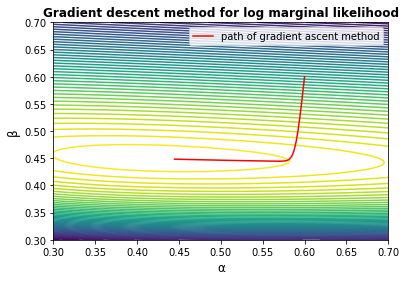

In [6]:
contour_plot(0.6,0.6,Phi_order_1,Y,0.001,0.000001,10000,50,0.3,0.7)

## Log marginal likelihood for trigonometric basis functions

In [7]:
# Trigonometric functions

def trig_phi(Phi,Y,dim,N):
    D = np.zeros((2*(dim+1)+1)*N).reshape(N,2*(dim+1)+1)
    D[:,0] = 1
    for i in range(1,dim+2):
        D[:,2*i-1] = np.sin(2*np.pi*i*Phi).T
        D[:,2*i] = np.cos(2*np.pi*i*Phi).T
    return D

In [8]:
trig_values = []

for dim in range(12):
    Phi_trig = trig_phi(X,Y,dim,N)
    trig_alpha_opt, trig_beta_opt, trig_func_value, trig_iterations = gradient_descent(0.45,0.45,Phi_trig,Y,0.00001,0.00001,10000)
    trig_values.append(trig_func_value[-1])

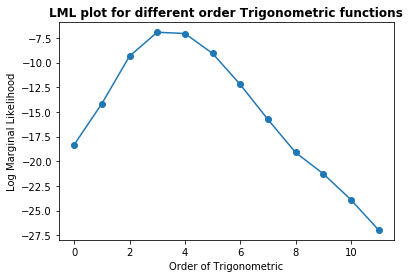

In [9]:
orders = [i for i in range(12)]

plt.plot(orders,trig_values,marker='o')
plt.ylabel('Log Marginal Likelihood')
plt.xlabel('Order of Trigonometric')
plt.title('LML plot for different order Trigonometric functions',fontsize=12,loc='center',fontweight='bold')
plt.savefig('plot_1c')
plt.show()

## Bayesian linear regression for Gaussian basis functions

In [10]:
np.random.seed(1)

order = 10

means = np.linspace(-0.5,1.,order)

alpha_gauss = 1.
beta_gauss = 0.1

def gauss(x,mean,scale):
    return np.exp(-((x-mean)**2)/(2*scale**2))

def gauss_phi(X, Y, dim, N, means,scale):
    D = np.zeros((dim+1)*N).reshape(N,dim+1)
    D[:,0] = 1
    for i in range(1,dim+1):
        D[:,i] = gauss(X,means[i-1],scale).T
    return D

def posterior(alpha,beta,Phi,Y):
    n, m = Phi.shape
    S0 = alpha*np.eye(m)
    
    SN = np.linalg.inv((np.linalg.inv(S0) + (1./beta)*np.dot(Phi.T,Phi)))
    mN = np.dot(SN,(1./beta)*np.dot(Phi.T,Y))
    MN = np.squeeze(mN)
    samples = np.random.multivariate_normal(MN,SN,5)
    
    return samples, mN, SN

Phi_gauss = gauss_phi(X,Y,10,N,means,0.1)

sample_params, mN, SN = posterior(1,0.1,Phi_gauss,Y)

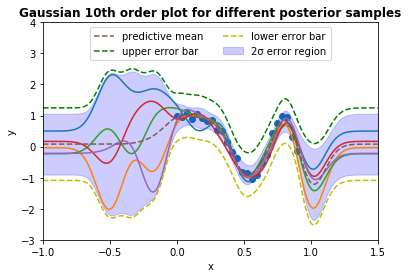

In [11]:
low = -1.
high = 1.5
points = 200

test = np.reshape(np.linspace(low, high, points), (points, 1))
plt.scatter(X,Y)

for index, param in enumerate(sample_params):
    theta_sample = param
    Phi_gauss_test = gauss_phi(test,Y,10,len(test),means,0.1)
    prediction = np.dot(Phi_gauss_test,theta_sample)   
    plt.plot(test,prediction)
    
predictive_mean = np.dot(mN.T,Phi_gauss_test.T).T
new_sigma = np.sqrt(np.diag(np.linalg.multi_dot([Phi_gauss_test,SN,Phi_gauss_test.T])).reshape(predictive_mean.shape[0],1))
sigma_noise = np.sqrt(np.diag(np.linalg.multi_dot([Phi_gauss_test,SN,Phi_gauss_test.T])+beta_gauss*np.eye(Phi_gauss_test.shape[0])).reshape(predictive_mean.shape[0],1))
upper_bound = np.add(predictive_mean,2*new_sigma)
lower_bound = np.subtract(predictive_mean,2*new_sigma)
upper_noise = np.add(predictive_mean,2*(sigma_noise))
lower_noise = np.subtract(predictive_mean,2*(sigma_noise))
    
plt.plot(test,predictive_mean,'--',label='predictive mean')
plt.plot(test,upper_noise,'g--',label='upper error bar')
plt.plot(test,lower_noise,'y--',label='lower error bar')
plt.fill_between(np.squeeze(test),np.squeeze(upper_bound),np.squeeze(lower_bound),color='b',alpha=0.2,label='2σ error region')
plt.xlim([-1.,1.5])
plt.ylim([-3,4])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian 10th order plot for different posterior samples',fontsize=12,loc='center',fontweight='bold')
plt.legend(loc='upper center',ncol=2)
plt.savefig('plot_1d')
plt.show()